In [1]:
# =========================================================
# Nested NPIV (linear baselines): sequential vs sparse variants
# =========================================================

import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

sys.path.append(str(Path.cwd() / "../../simulations"))
import dgps_nested as dgps

from nnpiv.linear import (
    sparse_l2vsl2,
    sparse_ridge_l2vsl2,
    sparse2_l2vsl2,
    sparse2_ridge_l2vsl2,
)

# ---------
# Settings
# ---------
plt.style.use("seaborn-v0_8-white")
plt.rcParams["figure.dpi"] = 120

def seed_everything(seed: int = 123) -> None:
    """Reproducibility for NumPy (and anything downstream using it)."""
    np.random.seed(seed)

seed_everything(123)

# =========================================================
# Data generation 
# =========================================================
# Function dictionary (for reference):
# {'abs': 0, '2dpoly': 1, 'sigmoid': 2, 'sin': 3, 'frequent_sin': 4, 'abs_sqrt': 5,
#  'step': 6, '3dpoly': 7, 'linear': 8, 'rand_pw': 9, 'abspos': 10, 'sqrpos': 11,
#  'band': 12, 'invband': 13, 'steplinear': 14, 'pwlinear': 15, 'exponential': 16}

fn_number = 8
tau_fn = dgps.get_tau_fn(fn_number)

# A, D are first stage (endog + instruments); B, C are second stage; Y is outcome
A, D, B, C, Y, tau_fn = dgps.get_data(3000, 10, 10, tau_fn, 2)

# ---------------------------------------
# Build test grid (vary B[:,0] for plots)
# ---------------------------------------
def make_test_grid(X: np.ndarray, var_idx: int = 0, n: int = 1000,
                   q_low: float = 5.0, q_high: float = 95.0) -> np.ndarray:
    """
    Sweep one coordinate (var_idx) between given quantiles; hold others at median.
    Returns a sorted grid by the swept coordinate.
    """
    grid = np.tile(np.median(X, axis=0, keepdims=True), (n, 1))
    grid[:, var_idx] = np.linspace(
        np.percentile(X[:, var_idx], q_low),
        np.percentile(X[:, var_idx], q_high),
        n,
    )
    return grid[np.argsort(grid[:, var_idx])]

B_test = make_test_grid(B, var_idx=0, n=1000)
true_fn = tau_fn(B_test)  # ground-truth structural function h(B)

# ---------------------------------------------------------
# Sequential nested NPIV with polynomial feature expansion
# ---------------------------------------------------------
def nested_npivfit_poly(
    A: np.ndarray, B: np.ndarray, C: np.ndarray, D: np.ndarray, Y: np.ndarray,
    B_test: np.ndarray,
    model, *, deg_A: int = 2, deg_B: int = 2
) -> np.ndarray:
    """
    Two-step linear baseline with polynomial expansions:
      Stage 1: fit g(A) using instruments D
      Stage 2: fit h(B) using instruments C, target = g_hat(A)

    We use *separate* PolynomialFeatures for (D,A) and (C,B) to respect
    different input dimensions.

    Parameters
    ----------
    model : object
        Must implement .fit(Z, T, Y) and .predict(T_new) for both stages.
    deg_A, deg_B : int
        Polynomial degree for (D,A) and (C,B) expansions.

    Returns
    -------
    y_pred_test : (len(B_test), 1) ndarray
        Predicted structural function h(B_test).
    """
    # Build polynomial mappers (fit on the instruments to lock input dim)
    poly_A = PolynomialFeatures(degree=deg_A, include_bias=False)
    poly_B = PolynomialFeatures(degree=deg_B, include_bias=False)

    D_poly = poly_A.fit_transform(D)
    A_poly = poly_A.transform(A)

    C_poly = poly_B.fit_transform(C)
    B_poly = poly_B.transform(B)
    Btest_poly = poly_B.transform(B_test)

    # Stage 1: estimate g(A) with instruments D
    model.fit(D_poly, A_poly, Y)
    g_hat = model.predict(A_poly).reshape(A.shape[0], -1)  # (n, 1)

    # Stage 2: estimate h(B) with instruments C, target = g_hat(A)
    model.fit(C_poly, B_poly, g_hat)
    y_pred_test = model.predict(Btest_poly).reshape(B_test.shape[0], -1)

    return y_pred_test

In [2]:
# -----------------------------
# 1) Sequential (same model)
# -----------------------------
# L2-vs-L2 (sparse) — degree 1
splin_1 = sparse_l2vsl2(
    B=100, lambda_theta=0.1,
    eta_theta=0.1, eta_w=0.1,
    n_iter=10_000, tol=1e-4, sparsity=None
)
splin_1_pred = nested_npivfit_poly(A, B, C, D, Y, B_test, model=splin_1, deg_A=1, deg_B=1)

# Ridge variant — degree 1
splin_2 = sparse_ridge_l2vsl2(
    B=100, lambda_theta=0.025,
    eta_theta=0.1, eta_w=0.1,
    n_iter=20_000, tol=1e-4, sparsity=None
)
splin_2_pred = nested_npivfit_poly(A, B, C, D, Y, B_test, model=splin_2, deg_A=1, deg_B=1)

# ---------------------------------------
# 2) Joint (simultaneous) linear baselines
# ---------------------------------------
# These take (A,B,C,D,Y) directly and estimate both stages jointly.
splin_3 = sparse2_l2vsl2(
    mu=0.1, V1=100, V2=100,
    eta_alpha="auto", eta_w1="auto", eta_beta="auto", eta_w2="auto",
    n_iter=10_000, tol=5e-5, sparsity=None, fit_intercept=True
)
splin3_pred = splin_3.fit(A, B, C, D, Y).predict(B_test)

splin_4 = sparse2_ridge_l2vsl2(
    mu=0.025, V1=100, V2=100,
    eta_alpha="auto", eta_w1="auto", eta_beta="auto", eta_w2="auto",
    n_iter=20_000, tol=5e-5, sparsity=None, fit_intercept=True
)
splin4_pred = splin_4.fit(A, B, C, D, Y).predict(B_test)

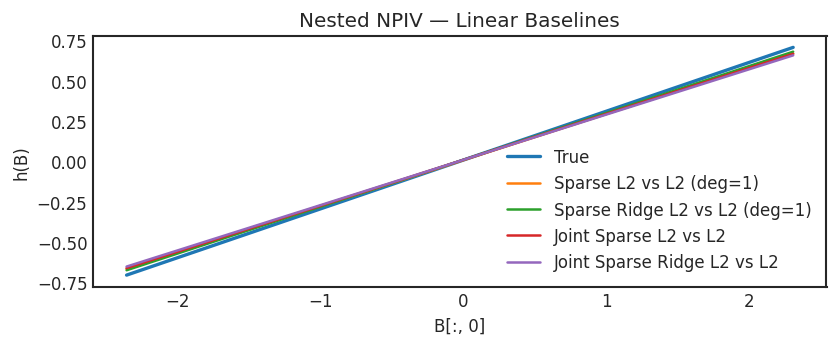

In [3]:
# ----------
# Plotting
# ----------
plt.figure(figsize=(7, 3))
plt.plot(B_test[:, 0], true_fn, label="True", linewidth=2)
plt.plot(B_test[:, 0], splin_1_pred.ravel(), label="Sparse L2 vs L2 (deg=1)")
plt.plot(B_test[:, 0], splin_2_pred.ravel(), label="Sparse Ridge L2 vs L2 (deg=1)")
plt.plot(B_test[:, 0], splin3_pred.ravel(), label="Joint Sparse L2 vs L2")
plt.plot(B_test[:, 0], splin4_pred.ravel(), label="Joint Sparse Ridge L2 vs L2")
plt.xlabel("B[:, 0]")
plt.ylabel("h(B)")
plt.legend(frameon=False)
plt.title("Nested NPIV — Linear Baselines")
plt.tight_layout()
plt.show()